In [1]:
from functools import partial

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sympy as sy
import y0
from sklearn.metrics import r2_score
from y0.dsl import Variable
from y0.graph import NxMixedGraph

from nocap import scm, utility

np.random.seed(42)
#!pip install pgmpy

## load e. coli network

In [2]:
ecoli_filepath = "./ecoli/ecoli_full_network_no_small_rna.graphml"
ecoli_network = nx.read_graphml(ecoli_filepath)

## get fadR subnetwork

In [3]:
# fadR
fadr_graph = utility.get_subgraph_from_nodes(ecoli_network, ["fadR"], descendants_only=False)
fadr_graph_dag = utility.convert_to_acyclic_graph(fadr_graph, "fadR")
fadr_graph_mixed = NxMixedGraph.from_str_edges(directed=fadr_graph_dag.edges)

print(f"{len(fadr_graph_mixed.directed.nodes)} nodes")
print(f"{len(fadr_graph_mixed.directed.edges)} edges")

109 nodes
426 edges


## simulate data for fadR subnetwork using linear model

In [4]:
# fadr_node_generators = {
#     node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
# }
# fadr_edge_weights = {
#     edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_node_generators = {
    node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
}
# fadr_edge_weights = {
#     edge: np.random.uniform(low=-1, high=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_edge_weights = {
    edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
}

n_samples = 10000

fadr_df_lscm = scm.simulate_lscm(
    graph=fadr_graph_mixed,
    node_generators=fadr_node_generators,
    edge_weights=fadr_edge_weights,
    n_samples=n_samples,
)

print(fadr_df_lscm.head())

       nsrR      arcA      fabR      basR      alpA     c0293      btsR  \
0 -0.964923  0.686051  1.058424 -1.758739 -1.183259 -2.039232 -0.269407   
1  0.047399 -0.860413 -0.384556  1.006293 -0.576892  0.835692 -1.129707   
2 -0.245743 -0.272724 -2.696887 -0.054295 -0.230935  0.696206  1.848956   
3  1.053642 -0.949399  2.632382  0.493318  0.184836 -0.858358  0.700310   
4  1.547505  1.795878 -0.612789 -0.387702  0.285865  0.334457  0.658544   

       ptrR      rcdA      glrR  ...      rcsA       csgD       fliZ  \
0  0.717542  1.502357  0.074095  ...  3.252428  44.841076 -29.488751   
1  0.529804  1.441569 -2.471645  ... -2.785819 -20.820768  -5.403855   
2  1.126565 -0.268889 -1.106526  ...  2.792867  30.699317 -30.170862   
3 -0.575638  0.122010  2.560085  ...  0.018155   5.565043  12.422874   
4  2.010205 -0.176947 -0.798297  ... -0.979592 -21.290388  26.108142   

        flhC       flhD       fliA       iclR       aceA       aceB       aceK  
0 -45.631664 -27.376901 -31.793904 

## calibrate linear fadR model to data

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_35174/2912437397.py:1: UserWarning: Correlation matrix contains 3 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 5.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_35174/2912437397.py:1: UserWarning: Correlation matrix contains 3 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 12.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_35174/2912437397.py:1: UserWarning: Correlation matrix contains 1 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 7.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5c

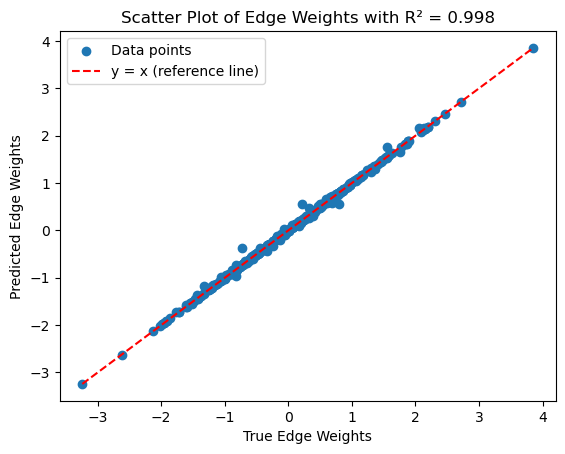

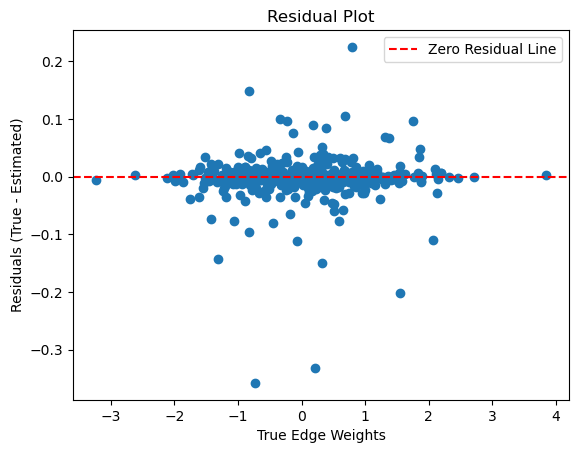

In [5]:
fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)


def plot_scatter_with_r2(exp_edges, pred_edges):
    exp_values = np.array([exp_edges[edge] for edge in exp_edges])
    pred_values = np.array([pred_edges[edge] for edge in pred_edges])

    # Calculate R^2 value
    r2 = r2_score(exp_values, pred_values)

    # Create scatter plot
    plt.scatter(exp_values, pred_values, label="Data points")
    max_val = max(np.max(exp_values), np.max(pred_values))
    min_val = min(np.min(exp_values), np.min(pred_values))
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Predicted Edge Weights")
    plt.title(f"Scatter Plot of Edge Weights with R² = {r2:.3f}")
    plt.legend()
    plt.show()


def plot_residuals(true_weights, estimated_weights):
    true_values = np.array([value for value in true_weights.values()])
    estimated_values = np.array([value for value in estimated_weights.values()])

    # Calculate residuals
    residuals = true_values - estimated_values

    # Scatter plot of residuals
    plt.scatter(true_values, residuals)
    plt.axhline(0, color="r", linestyle="--", label="Zero Residual Line")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Residuals (True - Estimated)")
    plt.title("Residual Plot")
    plt.legend()
    plt.show()


# Example usage
plot_scatter_with_r2(fadr_edge_weights, fadr_edge_weight_estimates)

plot_residuals(fadr_edge_weights, fadr_edge_weight_estimates)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  3.,  0.,  3.,  3.,  3., 12.,
        20., 18., 25., 31., 45., 42., 43., 41., 39., 34., 16., 18., 20.,
         4.,  4.,  1.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-8.74034959, -8.46780303, -8.19525647, -7.92270991, -7.65016336,
        -7.3776168 , -7.10507024, -6.83252368, -6.55997712, -6.28743056,
        -6.01488401, -5.74233745, -5.46979089, -5.19724433, -4.92469777,
        -4.65215122, -4.37960466, -4.1070581 , -3.83451154, -3.56196498,
        -3.28941842, -3.01687187, -2.74432531, -2.47177875, -2.19923219,
        -1.92668563, -1.65413908, -1.38159252, -1.10904596, -0.836499

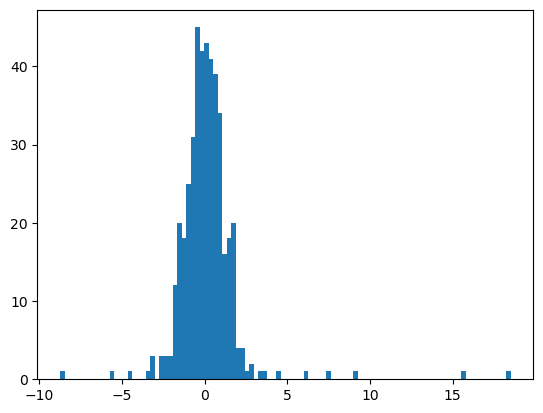

In [21]:
fadr_edge_weight_values = np.array([value for value in fadr_edge_weights.values()])
fadr_edge_weight_values_predicted = np.array(
    [value for value in fadr_edge_weight_estimates.values()]
)

#plt.hist(fadr_edge_weight_values, bins=100)
plt.hist(fadr_edge_weight_values_predicted, bins=100)

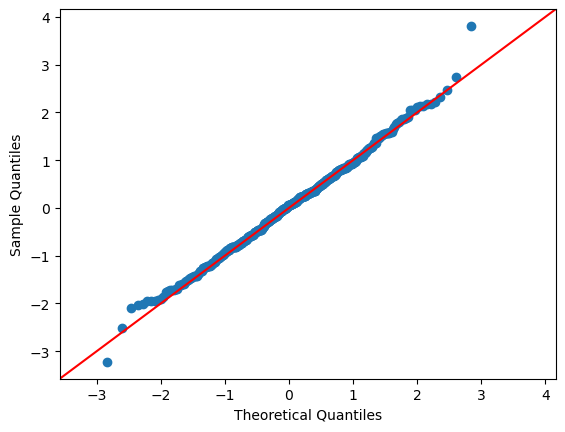

In [7]:
import numpy as np
import pylab as py
import statsmodels.api as sm

# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code
# the graph look different than shown below.

# Random data points generated
data_points = np.array([v for v in fadr_edge_weight_estimates.values()])

# fadr_edge_weight_estimates

sm.qqplot(data_points, line="45")
py.show()

## perform intervention on fadR subnetwork and simulate interventional data from calibrated model

In [9]:
fadr_intervened_lscm_calibrated = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weight_estimates,
)

fadr_df_lscm_calibrated_intervened = pd.DataFrame(
    {
        trial: {
            variable.name: values
            for variable, values in fadr_intervened_lscm_calibrated.trial().items()
        }
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_calibrated_intervened.head())

       rcdA  fadR      btsR      basR      fabR      ptrR      alpA      nsrR  \
0 -1.380135  10.0  0.718863  2.020001 -0.591883  0.636196 -1.132677  1.050044   
1 -1.249498  10.0  0.749757 -0.522308  0.170877 -0.465833 -0.025226  0.069478   
2 -0.311928  10.0  1.048295 -0.215257 -0.333588  0.465659  0.934905 -0.251603   
3 -0.559436  10.0 -0.846651  1.346772 -0.131846  0.695677  0.003300  0.390280   
4  0.002356  10.0  0.535894  0.622148  0.458859  0.615337 -2.973769  0.142422   

       glrR      glaR  ...       marR       gadW       csgD        flhC  \
0 -0.979324  0.522743  ...   1.661138 -22.243603  55.925813  -78.766312   
1  0.841002 -0.245908  ...  -4.380997 -21.369325  44.265144 -103.616051   
2  0.261149 -1.675011  ...  17.912071   8.337822 -12.211152   65.517703   
3  1.224750  0.717897  ...  12.621712 -28.486419  49.479014  -41.771464   
4 -0.606775  0.996257  ...   6.273928  -8.575252 -46.855775   56.481350   

        flhD       marA       iclR       aceA        aceB     

## perform intervention on fadR subnetwork and simulate interventional data from actual model

In [10]:
fadr_intervened_lscm = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weights,
)

fadr_df_lscm_intervened = pd.DataFrame(
    {
        trial: {variable.name: values for variable, values in fadr_intervened_lscm.trial().items()}
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_intervened.head())

       rcdA  fadR      btsR      basR      fabR      ptrR      alpA      nsrR  \
0 -2.321814  10.0  1.530103  0.083151 -0.794369 -0.087736 -0.855702  0.404570   
1 -0.876541  10.0 -0.013536  2.807670  1.157891 -0.027642 -0.300598  0.723947   
2  0.753389  10.0 -1.052373  0.635127 -0.481260  0.295364  0.131382  0.395862   
3  0.029043  10.0 -1.411356  0.515217  0.785680 -1.601763 -0.897895 -0.252059   
4 -0.687416  10.0  0.770699 -0.457810  0.159107  0.518806 -0.829383 -1.270875   

       glrR      glaR  ...       marR       gadW       csgD       flhC  \
0  1.038025  1.284486  ...   4.899623   3.232712  14.277518   3.398152   
1 -0.068614 -1.565599  ...  17.240007  30.705296 -45.330133  99.898132   
2 -0.909766 -1.010357  ...  -1.242614 -25.120462  71.295305 -91.071560   
3  0.363942 -0.307585  ... -17.488557 -28.764120  47.540390 -98.397179   
4  1.073855  1.137390  ...   8.775470  -3.091974  11.916296   1.307503   

        flhD       marA       iclR       aceA        aceB       aceK

## calculate expected and predicted average treatment effect of fadR linear model

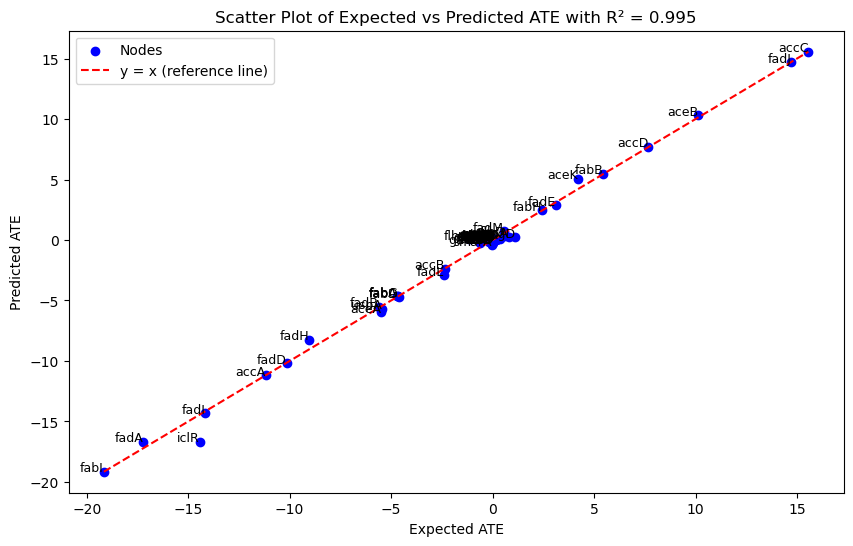

In [11]:
targets_list = [
    node for node in fadr_graph_mixed.nodes() if node.name != "fadR"
]  # all nodes except intervened node 'fadR'


expected_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_intervened, targets_list
)
predicted_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_calibrated_intervened, targets_list
)

# print(f"expected ATE:{expected_fadr_ATE}")
# print(f"actual ATE:{predicted_fadr_ATE}")


# Extract values in the same order
expected_values = np.array([expected_fadr_ATE[node] for node in expected_fadr_ATE])
predicted_values = np.array([predicted_fadr_ATE[node] for node in predicted_fadr_ATE])

# Calculate R2 value
r2 = r2_score(expected_values, predicted_values)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(expected_values, predicted_values, color="blue", label="Nodes")

# Add node labels
for i, node in enumerate(expected_fadr_ATE.keys()):
    plt.text(expected_values[i], predicted_values[i], node, fontsize=9, ha="right")

# Reference line (y=x)
max_val = max(np.max(expected_values), np.max(predicted_values))
min_val = min(np.min(expected_values), np.min(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")

# Add labels and title
plt.xlabel("Expected ATE")
plt.ylabel("Predicted ATE")
plt.title(f"Scatter Plot of Expected vs Predicted ATE with R² = {r2:.3f}")
plt.legend()

plt.show()

In [12]:
# sergio data

# microsplit data

In [ ]:
# def get_single_door_updated(
#     graph: NxMixedGraph, data: pd.DataFrame
# ) -> dict[tuple[Variable, Variable], float]:
#     """Estimate parameter values for a linear SCM using backdoor adjustment."""
#     rv = {}

#     for source, target in graph.directed.edges():
#         temp_graph = graph.copy()
#         temp_graph.directed.remove_edge(source, target)  # remove edge from source to target
#         pgmpy_graph = to_pgmpy_bayesian_network_updated(temp_graph)
#         try:
#             raw_adjustment_sets = pgmpy_graph.minimal_dseparator(source.name, target.name)
#             if raw_adjustment_sets is None:
#                 # There are no valid adjustment sets.
#                 continue
#             # Ensure we have a set of frozensets, with each frozenset containing variable names
#             adjustment_sets = {
#                 (
#                     frozenset([adjustment_set])
#                     if isinstance(adjustment_set, str)
#                     else frozenset(adjustment_set)
#                 )
#                 for adjustment_set in raw_adjustment_sets
#             }
#         except ValueError:
#             # There are no valid adjustment sets.
#             continue
#         if not adjustment_sets:
#             # There is a valid adjustment set, and it is the empty set, so just regress the target on the source.
#             adjustment_sets = frozenset([frozenset([])])
#         coefficients = []
#         for adjustment_set in adjustment_sets:
#             # Ensure adjustment_set is a set before performing the union operation.
#             variables = sorted(set(adjustment_set) | {source.name})
#             idx = variables.index(source.name)
#             model = LinearRegression()
#             model.fit(data[variables], data[target.name])
#             coefficients.append(model.coef_[idx])
#         rv[source, target] = fmean(coefficients)
#     return rv


# def to_pgmpy_bayesian_network_updated(graph: NxMixedGraph) -> BayesianNetwork:
#     """Convert a mixed graph to an equivalent :class:`pgmpy.BayesianNetwork`."""

#     # Get all directed edges with node names
#     edges = [(u.name, v.name) for u, v in graph.directed.edges()]

#     # Initialize set for latent variables
#     latents = set()

#     # Handle undirected edges by introducing latent variables
#     for u, v in graph.undirected.edges():
#         latent = f"U_{u.name}_{v.name}"
#         latents.add(latent)
#         edges.append((latent, u.name))
#         edges.append((latent, v.name))

#     # Initialize the BayesianNetwork with edges
#     model = BayesianNetwork(ebunch=edges, latents=latents)

#     # Add all original nodes to the BayesianNetwork
#     for node in graph.directed.nodes():
#         if node.name not in model.nodes():
#             model.add_node(node.name)

#     return model


np.random.seed(42)


# create model
graph = example_graph  # NxMixedGraph

graph.draw(prog="neato")

node_generators = {node: partial(uniform, low=2.0, high=4.0) for node in graph.nodes()}

edge_weights = {edge: uniform(low=1.0, high=2.0) for edge in graph.directed.edges()}
print(f"actual edge weights: {edge_weights}")


# simulate data
# df, fits = simulate(graph=graph, trials=100000, generators=node_generators, weights=edge_weights)

df = scm.simulate_lscm(
    graph=graph, node_generators=node_generators, edge_weights=edge_weights, n_samples=100000
)

display(df.head())

# calibrate model (edge weights) to data
# estimated_edge_weights = get_single_door_updated(graph, df)

estimated_edge_weights = scm.calibrate_lscm(graph, df)
print(f"estimated edge weights: {estimated_edge_weights}")

print(graph.directed.edges)

for edge, weight in edge_weights.items():
    estimated_weight = estimated_edge_weights[edge]
    # Use numpy.allclose to compare the weights with a tolerance
    assert np.allclose(
        weight, estimated_weight, atol=1e-2
    ), f"Edge {edge}: expected {weight}, got {estimated_weight}"

In [ ]:
intervention_node = (Variable("V4"), 10.0)
intervened_lscm = scm.intervene_on_lscm(graph, intervention_node, node_generators, edge_weights)

# Check resulting graph and edge weights
intervened_graph = intervened_lscm.graph
intervened_generators = intervened_lscm.generators
intervened_weights = intervened_lscm.weights

# Draw the intervened graph
intervened_lscm.graph.draw(prog="neato")

# The edge ('V1', 'V4') should be removed along with its weight
assert ("V1", "V4") not in intervened_weights, "Edge ('V1', 'V4') should be removed from weights"
assert (
    "V1",
    "V4",
) not in intervened_graph.directed.edges(), "Edge ('V1', 'V4') should be removed from graph"

# Check that the node generator for 'V4' returns 10
assert (
    intervened_generators[Variable("V4")]() == 10.0
), "Generator for 'V4' should return the intervention value"

print("All tests passed!")

In [ ]:
def remove_incoming_edge_weights(edges_dict, target_node):
    """Return a new dictionary with weights of incoming edges to the target node set to 0."""
    # Create a new dictionary to avoid modifying the original
    new_edges_dict = edges_dict.copy()

    # Iterate over the edges and update the weight if it's an incoming edge to the target node
    for edge, weight in edges_dict.items():
        if edge[1] == target_node:
            new_edges_dict[edge] = 0

    return new_edges_dict


intervention_target = V4
intervened_edge_weights = remove_incoming_edge_weights(edge_weights, intervention_target)
print(f"intervened_edge_weights: {intervened_edge_weights}")

intervened_df, intervened_fits = simulate(
    graph=graph, trials=10000, generators=node_generators, weights=intervened_edge_weights
)
print(intervened_df.head())

In [ ]:
def compute_average_treatment_effect(
    treatment1: pd.DataFrame, treatment2: pd.DataFrame, outcome_variables: list[Variable]
) -> dict[Variable, float]:
    "Computes the average treatment effect (i.e., E[Y1-Y0])."

    avg_treatment_effect_dict = {}
    for v in outcome_variables:
        avg_untreated = treatment1.loc[:, str(v)].mean()
        avg_treated = treatment2.loc[:, str(v)].mean()
        avg_treatment_effect = avg_treated - avg_untreated
        avg_treatment_effect_dict[v] = avg_treatment_effect
    return avg_treatment_effect_dict


avg_treatment_effect_dict = compute_average_treatment_effect(
    df, intervened_df, [V1, V2, V3, V4, V5, V6]
)
print(f"ATE - intervening on {intervention_target}: {avg_treatment_effect_dict}")

# E. Coli.

In [ ]:
from nocap import utility

np.random.seed(42)
# load ecoli network

file_path = "/Users/geor228/Github/nocap/notebooks/ecoli/ECOLI-regulatory-network.txt"
ecoli_network = utility.parse_regulation_file(file_path)

print(len(ecoli_network.edges))

# nx.write_graphml(ecoli_network, "ecoli_full_network.graphml")

## fadR

In [ ]:
# fadR
fadr_graph = utility.get_subgraph_from_nodes(ecoli_network, ["fadR"], descendants_only=False)
fadr_graph_dag = utility.convert_to_acyclic_graph_fancy(fadr_graph, "fadR")
fadr_graph_mixed = NxMixedGraph.from_str_edges(directed=fadr_graph_dag.edges)
print(len(fadr_graph_mixed.directed.nodes))
print(len(fadr_graph_mixed.directed.edges))

In [ ]:
# linear model
np.random.seed(42)
fadr_node_generators = {
    node: partial(uniform, low=-1.0, high=1.0) for node in fadr_graph_mixed.nodes()
}
fadr_edge_weights = {edge: uniform(low=0.0, high=1.0) for edge in fadr_graph_mixed.directed.edges()}
print(f"actual edge weights: {fadr_edge_weights}")

G = nx.DiGraph()

# Add edges and weights to the graph
for edge, weight in fadr_edge_weights.items():
    G.add_edge(edge[0], edge[1], weight=weight)

# Save the graph to a GraphML file (for visualization)
nx.write_graphml(G, "fadr_subnetwork_with_weights.graphml")

In [ ]:
# simulate data
fadr_df, fadr_fits = simulate(
    graph=fadr_graph_mixed, trials=1, generators=fadr_node_generators, weights=fadr_edge_weights
)
display(fadr_df.head())

In [ ]:
import cProfile
import io
import pstats


# Define your simulation function here
def profile_simulation():
    fadr_df, fadr_fits = simulate(
        graph=fadr_graph_mixed, trials=1, generators=fadr_node_generators, weights=fadr_edge_weights
    )


# Create a profiler object
profiler = cProfile.Profile()

try:
    # Start the profiler
    profiler.enable()

    # Run the simulation function
    profile_simulation()

    # Stop the profiler
    profiler.disable()

except KeyboardInterrupt:
    # Stop the profiler if interrupted (e.g., cell execution is canceled)
    profiler.disable()
    print("Profiling interrupted by user.")

finally:
    # Create a Stats object from the profiler's data
    stats = pstats.Stats(profiler, stream=io.StringIO()).sort_stats("cumulative")

    # Print the statistics to the console (or rather, to the notebook's output cell)
    stats.print_stats()

    # Retrieve the stats from the StringIO object and display them in the notebook
    print(stats.stream.getvalue())

    # Optionally, save the stats to a file for later analysis
    stats.dump_stats("profile_results.prof")

In [ ]:
#!pip install snakeviz

# # Load the SnakeViz extension in the Jupyter notebook
# %load_ext snakeviz

# # Visualize the saved profiling data with SnakeViz
# %snakeviz -t /Users/geor228/Github/nocap/notebooks/profile_results.prof

In [ ]:
# calibrate model (edge weights) to data
fadr_estimated_edge_weights = get_single_door_updated(fadr_graph_mixed, fadr_df)
print(f"estimated edge weights: {fadr_estimated_edge_weights}")

for edge, weight in fadr_edge_weights.items():
    estimated_weight = fadr_estimated_edge_weights[edge]
    # Use numpy.allclose to compare the weights with a tolerance
    assert np.allclose(
        weight, estimated_weight, atol=1e-2
    ), f"Edge {edge}: expected {weight}, got {estimated_weight}"


# # non-linear (Hill) model in SERGIO

In [ ]:
# simulate data for subnetworks

In [ ]:
# compute single door criterion

In [ ]:
# save

In [ ]:
def intervene_on_state_variable(
    model: NxMixedGraph, intervention: dict[y0.dsl.Variable, float]
) -> NxMixedGraph:
    pass


def intervene_on_parameter(
    model: NxMixedGraph, intervention: dict[sy.Symbol, float]
) -> NxMixedGraph:
    pass

In [ ]:
def sample_model(
    model: NxMixedGraph,
    n_samples: int,
    parameters: dict[sy.Symbol, float],
    parameter_interventions,
    state_interventions,
) -> pd.DataFrame:
    pass